In [1]:
import numpy as np
import os
from datetime import datetime
import nibabel as ni
import random
import matplotlib.pyplot as plt

In [2]:
def load_nii_file(file_path):
    data = ni.load(file_path)
    volume = np.nan_to_num(data.get_data().squeeze())
    return volume

def load_files(file_paths, d_type=None):
    images = []
    for path in file_paths:
        if d_type == None:
            images.append(load_nii_file(path))
        else: 
            images.append(load_nii_file(path).astype(d_type))
    return images


def to_onehot(matrix, labels=[], single_foregound_lable=True, background_channel=True, onehot_type=np.dtype(np.float32)):
    matrix = np.around(matrix)
    if len(labels) == 0:
        labels = np.unique(matrix) 
        labels = labels[1::]
    
    mask = np.zeros(matrix.shape, dtype=onehot_type)
    for i, label in enumerate(labels):
        mask += ((matrix == label) * (i+1))
   
    if single_foregound_lable:
        mask = (mask > 0)
        labels = [1]
        
    labels_len = len(labels)        
        
    onehot = np.zeros((labels_len+1,) + matrix.shape, dtype=onehot_type) 
    for i in range(mask.max()+1):
        onehot[i] = (mask == i)  
        
    if background_channel == False:
        onehot = onehot[1::] 
        
       
    return mask, onehot, labels

In [3]:
# Paths
output_path = './Data/Patches/'
dataset_folder = './Data/HCP_processed_data/'
subject_list = 'training_subjects_randomized.txt'

# Experiment definition
experiment_name = 'single_label'
Slice_view = "all"  # axial, cononal, and sagittal
# Slice_view = 'axial'
# Slice_view = 'coronal'
# Slice_view = 'sagittal'

# Patch_size = 32
Patch_size = 64
# Patch_size = 128

percentil_filt = 99.98  # percentile filtering to eliminate spike noises
normalize_volumes = [0,1]

# structure lookup tabel from each method
structure_indexes_sta = np.array([10, 49])
structure_indexes_free = np.array([10, 49])
structure_indexes_fsl = np.array([10, 49])
structure_indexes_qui = np.array([7, 25])
labels_indexes = [structure_indexes_sta, structure_indexes_free, structure_indexes_fsl, structure_indexes_qui]

#number of patches for each structure (background and foreground)
# N_PATCHES = [10, 25, 25] 
# N_PATCHES = [20, 100]
N_PATCHES = [10, 50]
single_foregound_lable=True
background_channel=True

input_channels = ['evalue1', 'FA', 'RD', 'MD', 'T1']
evalue1_sufix = 'diffusion/evalue1.nii.gz'
FA_sufix = 'diffusion/FA.nii.gz'
RD_sufix = 'diffusion/RD.nii.gz'
MD_sufix = 'diffusion/MD.nii.gz'
T1_sufix = 'T1w_acpc_dc_restore_1.25.nii.gz'
img_paths = [evalue1_sufix, FA_sufix, RD_sufix, MD_sufix, T1_sufix]

output_channels = ['staple', 'freesurfer', 'fsl', 'quicknat']
mask_sta_sufix = 'STAPLE/STAPLE_th0.5_thalamus_1.25.nii.gz'
mask_free_sufix = 'FreeSurfer/aparc+aseg_1.25_nearest.nii.gz'
mask_fsl_sufix = 'FSL/T1_first_all_fast_firstseg_1.25_nearest.nii.gz'
mask_qui_sufix = 'QuickNAT/segmentation_acpc_dc_restore_1.25_nearest.nii.gz'
msk_paths = [mask_sta_sufix, mask_free_sufix, mask_fsl_sufix, mask_qui_sufix]


input_d_type='float32'
output_d_type='int16'
save_patches = True

In [4]:
%%time
if Slice_view == "all":
    views = ["axial", "coronal", "sagittal"]
    print("Creating for all views")
else:
    views = [Slice_view]
    
for Slice_view in views:
    print(f"Processing view {Slice_view}.")
    patches_folder = output_path + experiment_name + '_psz{0:03d}/'.format(Patch_size) + Slice_view + '/'
    subjects = [line.strip() for line in open(subject_list)]
    p_size_half = np.floor(Patch_size/2).astype(int)

    os.makedirs(patches_folder, exist_ok=True) 

    f= open(patches_folder + "Patches_specs.txt","w+")
    f.write('creation time ' + datetime.now().strftime('%d/%m/%Y %H:%M') + '\r\n')
    f.write('\n input channels = ')
    f.write(' '.join(map(str, input_channels)) + '\r\n')
    f.write(' '.join(map(str, img_paths)) + '\r\n')
    f.write('\n output channels = ')
    f.write(' '.join(map(str, output_channels)) + '\r\n')
    f.write(' '.join(map(str, msk_paths)) + '\r\n')
    f.write('\n percentile = %f\r\n' % percentil_filt)
    f.write('\n normalization = ' + ' '.join(map(str, normalize_volumes)) + '\r\n')
    f.write('\n Patch size = %d\r\n' % Patch_size)
    f.write('\n number of patches = ' + ' '.join(map(str, N_PATCHES)) + '\r\n')
    f.write('\n structure labels = ' + ' '.join(map(str, labels_indexes)) + '\r\n')
    f.write('\n single foregound lable = %d\r\n' % single_foregound_lable)
    f.write('\n background channel = %d\r\n' % background_channel)
    f.write('\n input_d_type = ' + input_d_type + '\r\n')
    f.write('\n output_d_type = ' + output_d_type)
    f.close() 

    for subject in subjects:
        print('subject = ', subject)

        images = load_files([dataset_folder + subject + '/' +  s for s in img_paths])
        segmentations = load_files([dataset_folder + subject + '/' +  s for s in msk_paths], d_type=input_d_type)

        MSKS_OH = []
        MSKS = []
        for i, segmentation in enumerate(segmentations):
            msk, msk_oh, lbs = to_onehot(segmentation, labels=labels_indexes[i], single_foregound_lable=single_foregound_lable, 
                                         background_channel=background_channel, onehot_type=np.dtype(output_d_type))
            MSKS_OH.append(msk_oh)
            MSKS.append(msk)

        if percentil_filt > 0:
            for i in range(len(images)):
                images[i][images[i] > np.percentile(images[i], percentil_filt)] = np.percentile(images[i], percentil_filt)

        if len(normalize_volumes) == 2:
            for i in range(len(images)):
                images[i] = images[i] * ((normalize_volumes[1]-normalize_volumes[0])/(images[i].max()-images[i].min()))
                images[i] = images[i] - images[i].min() + normalize_volumes[0]          

        for i in range(len(N_PATCHES)):
            centers = np.where(MSKS_OH[0][i]>0)
    #         print('centers = ', centers)
            rand_vector = random.sample(range(len(centers[0])), N_PATCHES[i])
            centers = (centers[0][rand_vector], centers[1][rand_vector], centers[2][rand_vector])


            for j in range(len(centers[0])):
                PATCHES_img = []
                for k in range(len(images)):
                    if Slice_view == 'sagittal':
                        if centers[1][j] - p_size_half < 0:
                            centers[1][j] = p_size_half
                        if centers[2][j] - p_size_half < 0:
                            centers[2][j] = p_size_half  
                        if centers[1][j] + p_size_half >= images[k].shape[1]:
                            centers[1][j] = (images[k].shape[1] - p_size_half)# + 1
                        if centers[2][j] + p_size_half >= images[k].shape[2]:
                            centers[2][j] = (images[k].shape[2] - p_size_half)# + 1
                        PATCHES_img.append(images[k][centers[0][j], centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'coronal':
                        if centers[0][j] - p_size_half < 0:
                            centers[0][j] = p_size_half
                        if centers[2][j] - p_size_half < 0:
                            centers[2][j] = p_size_half 
                        if centers[0][j] + p_size_half >= images[k].shape[0]:
                            centers[0][j] = (images[k].shape[0] - p_size_half)# + 1
                        if centers[2][j] + p_size_half >= images[k].shape[2]:
                            centers[2][j] = (images[k].shape[2] - p_size_half)# + 1
                        PATCHES_img.append(images[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j], centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'axial':
                        if centers[0][j] - p_size_half < 0:
                            centers[0][j] = p_size_half
                        if centers[1][j] - p_size_half < 0:
                            centers[1][j] = p_size_half 
                        if centers[0][j] + p_size_half >= images[k].shape[0]:
                            centers[0][j] = (images[k].shape[0] - p_size_half)# + 1
                        if centers[1][j] + p_size_half >= images[k].shape[1]:
                            centers[1][j] = (images[k].shape[1] - p_size_half)# + 1
                        PATCHES_img.append(images[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j]])
                    else:
                        pass

                PATCHES_msk = []  
                PATCHES_mskoh = []   
                for k in range(len(MSKS)):
                    if Slice_view == 'sagittal':
                        PATCHES_msk.append(MSKS[k][centers[0][j], centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                        PATCHES_mskoh.append(MSKS_OH[k][:,centers[0][j], centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'coronal': 
                        PATCHES_msk.append(MSKS[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j], centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                        PATCHES_mskoh.append(MSKS_OH[k][:,centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j], centers[2][j] - p_size_half : centers[2][j] + p_size_half])
                    elif Slice_view == 'axial': 
                        PATCHES_msk.append(MSKS[k][centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j]])
                        PATCHES_mskoh.append(MSKS_OH[k][:,centers[0][j] - p_size_half : centers[0][j] + p_size_half, centers[1][j] - p_size_half : centers[1][j] + p_size_half, centers[2][j]])
                    else:
                        pass

                if PATCHES_msk[0].shape != (Patch_size, Patch_size):
                    print('ERROR!!')

                if save_patches:
    #                 print(PATCHES_msk[0].shape)
    #                 print(patches_folder + subject + '_struc' + format(i, '02d') + 'pN{0:03d}'.format(j) + '.npz')
                    np.savez_compressed(patches_folder + subject + '_struc' + format(i, '02d') + 'pN{0:03d}'.format(j) + '.npz',
                                        evalue1=PATCHES_img[0], 
                                        FA=PATCHES_img[1], 
                                        RD=PATCHES_img[2], 
                                        MD=PATCHES_img[3],
                                        T1=PATCHES_img[4], 

                                        staple=PATCHES_msk[0], 
                                        freesurfer=PATCHES_msk[1], 
                                        fsl=PATCHES_msk[2], 
                                        quicknat=PATCHES_msk[3], 

                                        staple_oh=PATCHES_mskoh[0], 
                                        freesurfer_oh=PATCHES_mskoh[1], 
                                        fsl_oh=PATCHES_mskoh[2], 
                                        quicknat_oh=PATCHES_mskoh[3])



Creating for all views
Processing view axial.
subject =  645551


<ipython-input-2-f93d75829233>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  volume = np.nan_to_num(data.get_data().squeeze())


subject =  558960
subject =  165941
subject =  153126
subject =  397760
subject =  109123
subject =  191235
subject =  111716
subject =  198653
subject =  578057
subject =  214524
subject =  156435
subject =  101107
subject =  706040
subject =  599671
subject =  633847
subject =  179952
subject =  173839
subject =  870861
subject =  818859
subject =  763557
subject =  156233
subject =  973770
subject =  166640
subject =  473952
subject =  175136
subject =  647858
subject =  161327
subject =  623844
subject =  219231
subject =  878776
subject =  165032
subject =  172029
subject =  145127
subject =  289555
subject =  445543
subject =  173536
subject =  108525
subject =  101006
subject =  128026
subject =  531536
subject =  672756
subject =  969476
subject =  529549
subject =  209329
subject =  286347
subject =  622236
subject =  127832
subject =  149539
subject =  356948
subject =  555651
subject =  104820
subject =  151526
subject =  163432
subject =  212015
subject =  206525
subject = 

subject =  917255
subject =  594156
subject =  453542
subject =  579665
subject =  100307
subject =  685058
subject =  412528
subject =  701535
subject =  123925
subject =  766563
subject =  849971
subject =  779370
subject =  108121
subject =  180533
subject =  117930
subject =  268749
subject =  131419
subject =  114823
subject =  371843
subject =  175338
subject =  749058
subject =  169949
subject =  468050
subject =  275645
subject =  143830
subject =  156334
subject =  227432
subject =  141422
subject =  195950
subject =  180937
subject =  390645
subject =  154835
subject =  720337
subject =  204622
subject =  987983
subject =  833148
subject =  833249
subject =  145632
subject =  588565
subject =  393550
subject =  734045
subject =  115825
subject =  196952
subject =  422632
subject =  180432
subject =  284646
subject =  118730
subject =  102109
subject =  601127
subject =  751348
subject =  177241
subject =  206323
subject =  186040
subject =  209935
subject =  693764
subject = 

subject =  192439
subject =  677766
subject =  153934
subject =  154936
subject =  553344
subject =  352738
subject =  657659
subject =  877269
subject =  362034
subject =  156536
subject =  896778
subject =  136631
subject =  761957
subject =  456346
subject =  382242
subject =  176744
subject =  308129
subject =  131722
subject =  280739
subject =  231928
subject =  350330
subject =  200917
subject =  103414
subject =  164131
subject =  185947
subject =  729557
subject =  309636
subject =  138837
subject =  735148
subject =  200513
subject =  205220
subject =  157942
subject =  171532
subject =  562345
subject =  880157
subject =  548250
subject =  192641
subject =  757764
subject =  134021
subject =  469961
subject =  499566
subject =  748662
subject =  132118
subject =  187143
subject =  173132
subject =  148941
subject =  131217
subject =  248339
subject =  204319
subject =  865363
Processing view coronal.
subject =  645551
subject =  558960
subject =  165941
subject =  153126
sub

subject =  926862
subject =  552241
subject =  957974
subject =  377451
subject =  325129
subject =  201414
subject =  760551
subject =  151324
subject =  341834
subject =  872764
subject =  189349
subject =  783462
subject =  149337
subject =  334635
subject =  559457
subject =  110613
subject =  159340
subject =  208226
subject =  239944
subject =  113922
subject =  803240
subject =  159744
subject =  348545
subject =  318637
subject =  869472
subject =  628248
subject =  103212
subject =  137229
subject =  991267
subject =  387959
subject =  192035
subject =  104012
subject =  820745
subject =  175540
subject =  125222
subject =  130518
subject =  163331
subject =  894673
subject =  751550
subject =  172938
subject =  397861
subject =  148133
subject =  432332
subject =  146331
subject =  965367
subject =  146432
subject =  121618
subject =  300719
subject =  283543
subject =  378857
subject =  937160
subject =  727654
subject =  581349
subject =  917255
subject =  594156
subject = 

subject =  123420
subject =  578158
subject =  173940
subject =  203923
subject =  715041
subject =  212116
subject =  187345
subject =  168947
subject =  413934
subject =  214221
subject =  171330
subject =  119025
subject =  590047
subject =  169545
subject =  972566
subject =  119126
subject =  198350
subject =  165840
subject =  112112
subject =  692964
subject =  295146
subject =  125525
subject =  987074
subject =  154431
subject =  825048
subject =  873968
subject =  193845
subject =  520228
subject =  333330
subject =  137936
subject =  281135
subject =  102614
subject =  852455
subject =  475855
subject =  204521
subject =  200109
subject =  500222
subject =  130922
subject =  194645
subject =  190031
subject =  525541
subject =  138231
subject =  562446
subject =  117122
subject =  962058
subject =  162329
subject =  134324
subject =  127630
subject =  715950
subject =  124422
subject =  168341
subject =  346137
subject =  178647
subject =  192439
subject =  677766
subject = 

subject =  626648
subject =  901139
subject =  211821
subject =  888678
subject =  193441
subject =  161832
subject =  547046
subject =  120414
subject =  908860
subject =  196346
subject =  965771
subject =  353740
subject =  943862
subject =  257845
subject =  151829
subject =  828862
subject =  585862
subject =  759869
subject =  557857
subject =  380036
subject =  140117
subject =  139637
subject =  698168
subject =  571548
subject =  156031
subject =  255639
subject =  168240
subject =  207426
subject =  942658
subject =  148032
subject =  111009
subject =  462139
subject =  100610
subject =  101915
subject =  765864
subject =  212419
subject =  160729
subject =  105014
subject =  884064
subject =  251833
subject =  181636
subject =  767464
subject =  756055
subject =  256540
subject =  162228
subject =  178142
subject =  173334
subject =  191033
subject =  958976
subject =  138332
subject =  250427
subject =  784565
subject =  200210
subject =  926862
subject =  552241
subject = 

subject =  310621
subject =  194847
subject =  118023
subject =  592455
subject =  521331
subject =  217429
subject =  391748
subject =  654350
subject =  111514
subject =  959574
subject =  979984
subject =  133019
subject =  561949
subject =  147636
subject =  167238
subject =  555954
subject =  211215
subject =  193239
subject =  228434
subject =  769064
subject =  304727
subject =  704238
subject =  185038
subject =  158035
subject =  680957
subject =  105115
subject =  663755
subject =  205725
subject =  679568
subject =  727553
subject =  245333
subject =  209228
subject =  517239
subject =  366042
subject =  214625
subject =  154532
subject =  164939
subject =  316835
subject =  146533
subject =  467351
subject =  197348
subject =  513736
subject =  155635
subject =  138534
subject =  169747
subject =  116221
subject =  150019
subject =  135730
subject =  148335
subject =  149741
subject =  188751
subject =  571144
subject =  107725
subject =  123420
subject =  578158
subject = 

In [5]:
images[i].shape

(145, 174, 145)

show input channels
show masks
show masks_oh


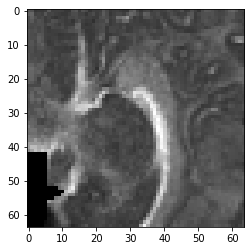

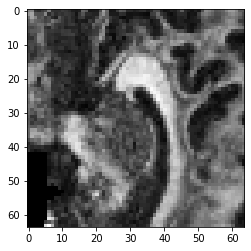

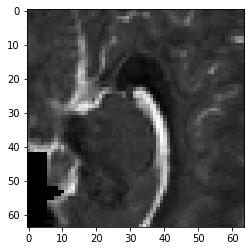

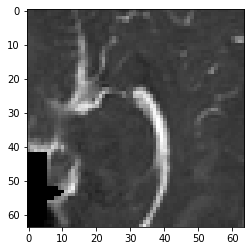

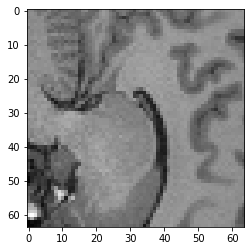

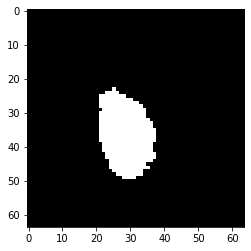

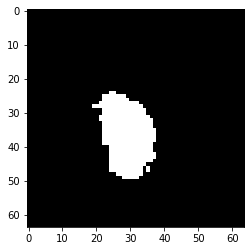

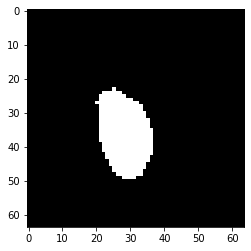

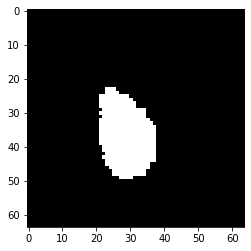

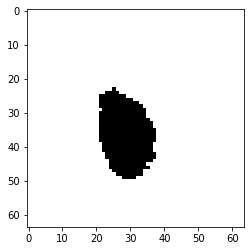

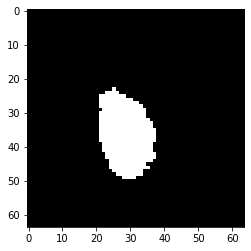

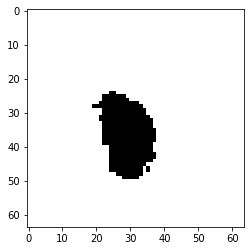

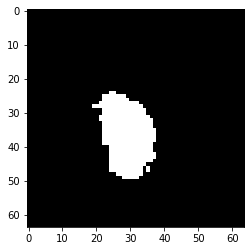

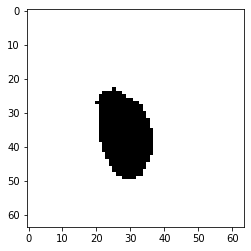

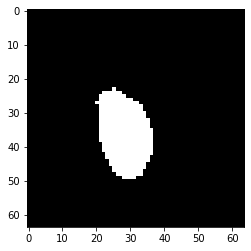

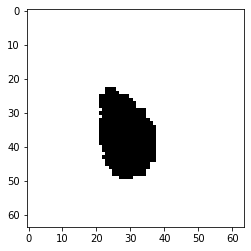

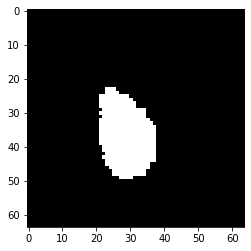

In [6]:
print('show input channels')
for channel in PATCHES_img:
    plt.figure()
    plt.imshow(channel,cmap='gray')
    
print('show masks')
for msk in PATCHES_msk:
    plt.figure()
    plt.imshow(msk,cmap='gray')
    
print('show masks_oh')
for msk in PATCHES_mskoh:
    for i in range(msk.shape[0]):
        plt.figure()
        plt.imshow(msk[i],cmap='gray')